# 베어링 RUL 예측을 위한 시계열 데이터 주피터 노트북 

## 코랩 사용시 여기로 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive

## 기본 시각화 및 라이브러리 세팅 

In [6]:
import warnings
warnings.filterwarnings('ignore')

import shutil
import zipfile
import os
import glob

import pickle # dump variables
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt # datetime lib

import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Matplotlib styles and plot again.
%matplotlib inline
plt.rcdefaults()

sns.set(rc={'figure.figsize': tuple(plt.rcParams['figure.figsize'])})
sns.set(style="whitegrid", font_scale=1.75)

# prettify plots
plt.rcParams['figure.figsize'] = [20.0, 5.0]
plt.rcParams['figure.dpi'] = 200
sns.set_palette(sns.color_palette("muted"))

## You can also just do this in Colab/Jupyter, some "magic":
%config InlineBackend.figure_format='retina'
# See https://ipython.org/ipython-doc/3/api/generated/IPython.display.html
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


## 데이터 불러오기 (코랩 or Local)

In [2]:
%cd ../data

/home/i4624/vscode/gitclone/SWbootProject_2023-7/Team-project/data


In [5]:
!unzip 'archive (1).zip'

Archive:  archive (1).zip
  inflating: ieee-phm-2012-data-challenge-dataset-master/Full_Test_Set/Bearing1_3/acc_00001.csv  
  inflating: ieee-phm-2012-data-challenge-dataset-master/Full_Test_Set/Bearing1_3/acc_00002.csv  
  inflating: ieee-phm-2012-data-challenge-dataset-master/Full_Test_Set/Bearing1_3/acc_00003.csv  
  inflating: ieee-phm-2012-data-challenge-dataset-master/Full_Test_Set/Bearing1_3/acc_00004.csv  
  inflating: ieee-phm-2012-data-challenge-dataset-master/Full_Test_Set/Bearing1_3/acc_00005.csv  
  inflating: ieee-phm-2012-data-challenge-dataset-master/Full_Test_Set/Bearing1_3/acc_00006.csv  
  inflating: ieee-phm-2012-data-challenge-dataset-master/Full_Test_Set/Bearing1_3/acc_00007.csv  
  inflating: ieee-phm-2012-data-challenge-dataset-master/Full_Test_Set/Bearing1_3/acc_00008.csv  
  inflating: ieee-phm-2012-data-challenge-dataset-master/Full_Test_Set/Bearing1_3/acc_00009.csv  
  inflating: ieee-phm-2012-data-challenge-dataset-master/Full_Test_Set/Bearing1_3/acc_00010.

In [88]:
%cd /home/i4624/vscode/gitclone/SWbootProject_2023-7/Team-project

# CSV 파일들이 있는 디렉토리 경로
directory_path = './data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_1'

# 디렉토리 내의 모든 CSV 파일 경로를 가져오기
file_paths = glob.glob(directory_path + '/*.csv')

# 파일 경로를 순서대로 정렬
file_paths = sorted(file_paths)

# 파일들을 담을 빈 DataFrame 생성
combined_data = pd.DataFrame()

# acc 파일만 불러오기 (파일명에 'acc'가 포함된 파일들)
acc_file_paths = [file_path for file_path in file_paths if 'acc' in file_path]

# 각 파일을 순회하며 데이터를 불러온 뒤 빈 DataFrame에 추가
for file_path in acc_file_paths:
    df = pd.read_csv(file_path, index_col=None,header = None)  # 첫 번째 행을 인덱스로 사용하지 않음
    combined_data = pd.concat([combined_data, df], ignore_index=True,axis = 0)

/home/i4624/vscode/gitclone/SWbootProject_2023-7/Team-project


In [89]:
file_paths

['./data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_1/acc_00001.csv',
 './data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_1/acc_00002.csv',
 './data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_1/acc_00003.csv',
 './data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_1/acc_00004.csv',
 './data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_1/acc_00005.csv',
 './data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_1/acc_00006.csv',
 './data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_1/acc_00007.csv',
 './data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_1/acc_00008.csv',
 './data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_1/acc_00009.csv',
 './data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_1/acc_00010.csv',
 './data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bear

In [90]:
combined_data

0   1   2         3      4      5
0         9  39  39   65664.0  0.552 -0.146
1         9  39  39   65703.0  0.501 -0.480
2         9  39  39   65742.0  0.138  0.435
3         9  39  39   65781.0 -0.423  0.240
4         9  39  39   65820.0 -0.802  0.020
...      ..  ..  ..       ...    ...    ...
7175675  17  26  39  165470.0 -3.353  2.129
7175676  17  26  39  165510.0 -2.868 -2.299
7175677  17  26  39  165550.0 -5.507 -1.844
7175678  17  26  39  165580.0 -3.578  2.146
7175679  17  26  39  165620.0 -2.709  0.470

[7175680 rows x 6 columns]

In [80]:
combined_data = pd.DataFrame(combined_data)

In [100]:
import datetime
def make_timestamp(data):
  """
  Converts pandas data to timestamp.

  Args:
    data: A pandas DataFrame with time data in the format "hh:mm:ss.sss".

  Returns:
    A pandas DataFrame with the time data converted to timestamp.
  """

  timestamp = []
  for time in data['time']:
    dt = datetime.datetime.strptime(time, '%H:%M:%S.%f')
    timestamp.append(dt.timestamp())

  data['timestamp'] = timestamp
  return data

In [104]:
timestamp = []
for i in range(len(combined_data)):
  time = combined_data.loc[i, ]
  dt = datetime.datetime.strptime(time, '%H:%M:%S.%f')
  timestamp.append(dt.timestamp())

TypeError: strptime() argument 1 must be str, not Series

In [101]:
combined_data['time'] = [
    '01:02:03.001',
    '04:05:06.002',
    '07:08:09.003',
  ]

timestamp_data = pd.DataFrame(combined_data)

timestamp_data = make_timestamp(combined_data)
timestamp_data['time'] = timestamp


ValueError: Length of values (3) does not match length of index (7175680)

In [105]:
# Convert timestamp columns to integers and create a new DataFrame with these values
timestamp_integers = combined_data[[0, 1, 2, 3]].astype(int)
timestamp_integers.columns = ['hour', 'minute', 'second', 'microsecond']

# Combine the integer values to form a string in the format 'HH:MM:SS.microseconds'
combined_data['timestamp'] = timestamp_integers.apply(lambda x: f"{x['hour']:02d}:{x['minute']:02d}:{x['second']:02d}.{x['microsecond']:06d}", axis=1)

# Convert the 'timestamp' column to a Pandas datetime object
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'], format='%H:%M:%S.%f')

In [81]:
def convert_to_datetime(row):
    hour = int(row[0])
    minute = int(row[1])
    second = int(row[2])
    microsecond = int(row[3])

    timestamp = f"{hour:02d}:{minute:02d}:{second:02d}.{microsecond:06d}"
    return pd.to_datetime(timestamp, format='%H:%M:%S.%f')

combined_data['timestamp'] = combined_data.apply(convert_to_datetime, axis=1)


In [106]:
combined_data['timestamp']

0         1900-01-01 09:39:39.065664
1         1900-01-01 09:39:39.065703
2         1900-01-01 09:39:39.065742
3         1900-01-01 09:39:39.065781
4         1900-01-01 09:39:39.065820
                     ...            
7175675   1900-01-01 17:26:39.165470
7175676   1900-01-01 17:26:39.165510
7175677   1900-01-01 17:26:39.165550
7175678   1900-01-01 17:26:39.165580
7175679   1900-01-01 17:26:39.165620
Name: timestamp, Length: 7175680, dtype: datetime64[ns]

In [107]:
combined_data

0   1   2         3      4      5                  timestamp
0         9  39  39   65664.0  0.552 -0.146 1900-01-01 09:39:39.065664
1         9  39  39   65703.0  0.501 -0.480 1900-01-01 09:39:39.065703
2         9  39  39   65742.0  0.138  0.435 1900-01-01 09:39:39.065742
3         9  39  39   65781.0 -0.423  0.240 1900-01-01 09:39:39.065781
4         9  39  39   65820.0 -0.802  0.020 1900-01-01 09:39:39.065820
...      ..  ..  ..       ...    ...    ...                        ...
7175675  17  26  39  165470.0 -3.353  2.129 1900-01-01 17:26:39.165470
7175676  17  26  39  165510.0 -2.868 -2.299 1900-01-01 17:26:39.165510
7175677  17  26  39  165550.0 -5.507 -1.844 1900-01-01 17:26:39.165550
7175678  17  26  39  165580.0 -3.578  2.146 1900-01-01 17:26:39.165580
7175679  17  26  39  165620.0 -2.709  0.470 1900-01-01 17:26:39.165620

[7175680 rows x 7 columns]

                       0     1     2              3         4         5
timestamp                                                              
1900-01-01 09:39:00  9.0  39.0  49.0  115643.941406  0.004423 -0.001680
1900-01-01 09:40:00  9.0  40.0  34.0  115643.941406  0.003007  0.001724
1900-01-01 09:41:00  9.0  41.0  34.0  115643.941406  0.000154  0.000006
1900-01-01 09:42:00  9.0  42.0  34.0  115643.941406  0.001669  0.003084
1900-01-01 09:43:00  9.0  43.0  34.0  115643.941406  0.001730 -0.001591
1900-01-01 09:44:00  9.0  44.0  34.0  115643.941406 -0.003177 -0.001098
1900-01-01 09:45:00  9.0  45.0  34.0  115643.941406  0.000015 -0.000219
1900-01-01 09:46:00  9.0  46.0  34.0  115643.941406 -0.002224  0.000183
1900-01-01 09:47:00  9.0  47.0  34.0  115643.941406 -0.000230 -0.001388
1900-01-01 09:48:00  9.0  48.0  34.0  115643.941406  0.001728  0.001099
1900-01-01 09:49:00  9.0  49.0  34.0  115643.941406  0.001806 -0.001182
1900-01-01 09:50:00  9.0  50.0  34.0  115643.941406 -0.003309  0

In [108]:
# Step 3: Downsample the data to reduce the number of points
downsampled_data = combined_data.set_index('timestamp').resample('100ms').mean()


In [109]:
# Step 3: Downsample the data by selecting every nth data point
n = len(combined_data) // 1000  # Adjust this value as needed for desired downsampling ratio
downsampled_data = combined_data.iloc[::n]

In [110]:
print(downsampled_data)

          0   1   2         3      4      5                  timestamp
0         9  39  39   65664.0  0.552 -0.146 1900-01-01 09:39:39.065664
7175      9  39  59  145940.0 -0.714  0.615 1900-01-01 09:39:59.145940
14350     9  40  29  126210.0  1.062  0.234 1900-01-01 09:40:29.126210
21525     9  40  59  106480.0 -0.495  0.043 1900-01-01 09:40:59.106480
28700     9  41  29   86757.0  0.754 -1.104 1900-01-01 09:41:29.086757
...      ..  ..  ..       ...    ...    ...                        ...
7146300  17  24  49  118010.0  0.104  2.651 1900-01-01 17:24:49.118010
7153475  17  25  19   98281.0 -2.927  0.043 1900-01-01 17:25:19.098281
7160650  17  25  49   78554.0 -0.631  0.006 1900-01-01 17:25:49.078554
7167825  17  26   9  158830.0  1.060  0.269 1900-01-01 17:26:09.158830
7175000  17  26  39  139100.0 -5.187  8.972 1900-01-01 17:26:39.139100

[1001 rows x 7 columns]


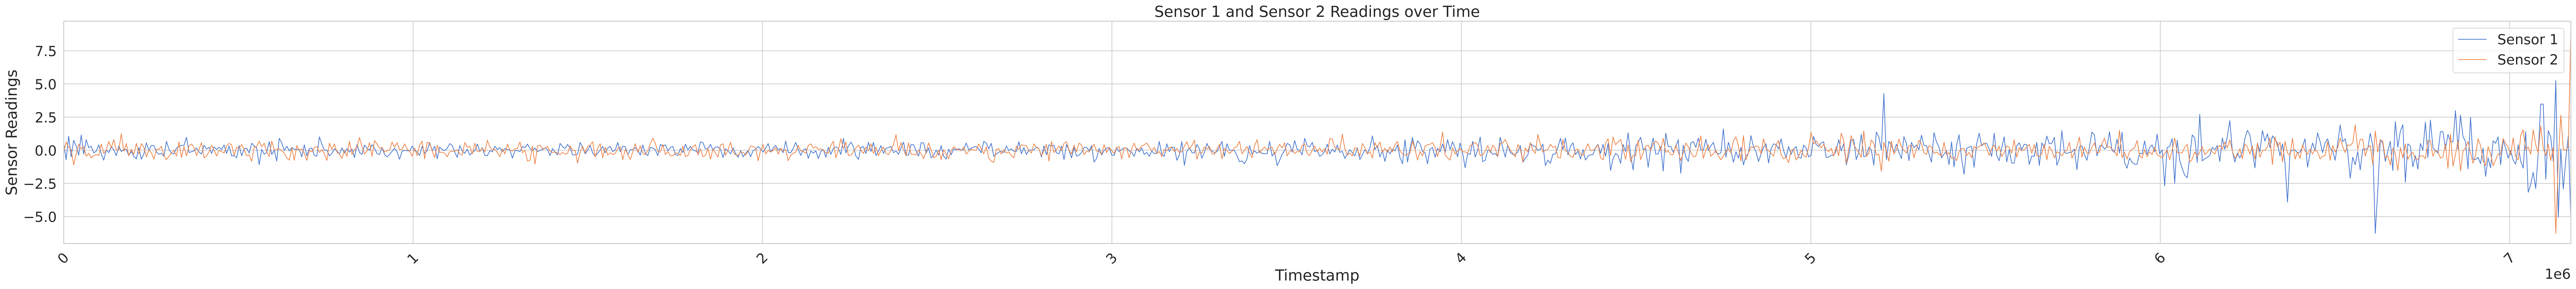

In [111]:
# Step 4: Plot the graph
plt.figure(figsize=(50, 6))

# Plot line graphs with narrower lines
plt.plot(downsampled_data.index, downsampled_data[4], label='Sensor 1', linewidth=1)
plt.plot(downsampled_data.index, downsampled_data[5], label='Sensor 2', linewidth=1)

plt.xlabel('Timestamp')
plt.ylabel('Sensor Readings')
plt.title('Sensor 1 and Sensor 2 Readings over Time')
plt.legend()
plt.xticks(rotation=45)
plt.xlim(downsampled_data.index.min(), downsampled_data.index.max())  # Set x-axis limits to show the full time range
plt.tight_layout()
plt.show()

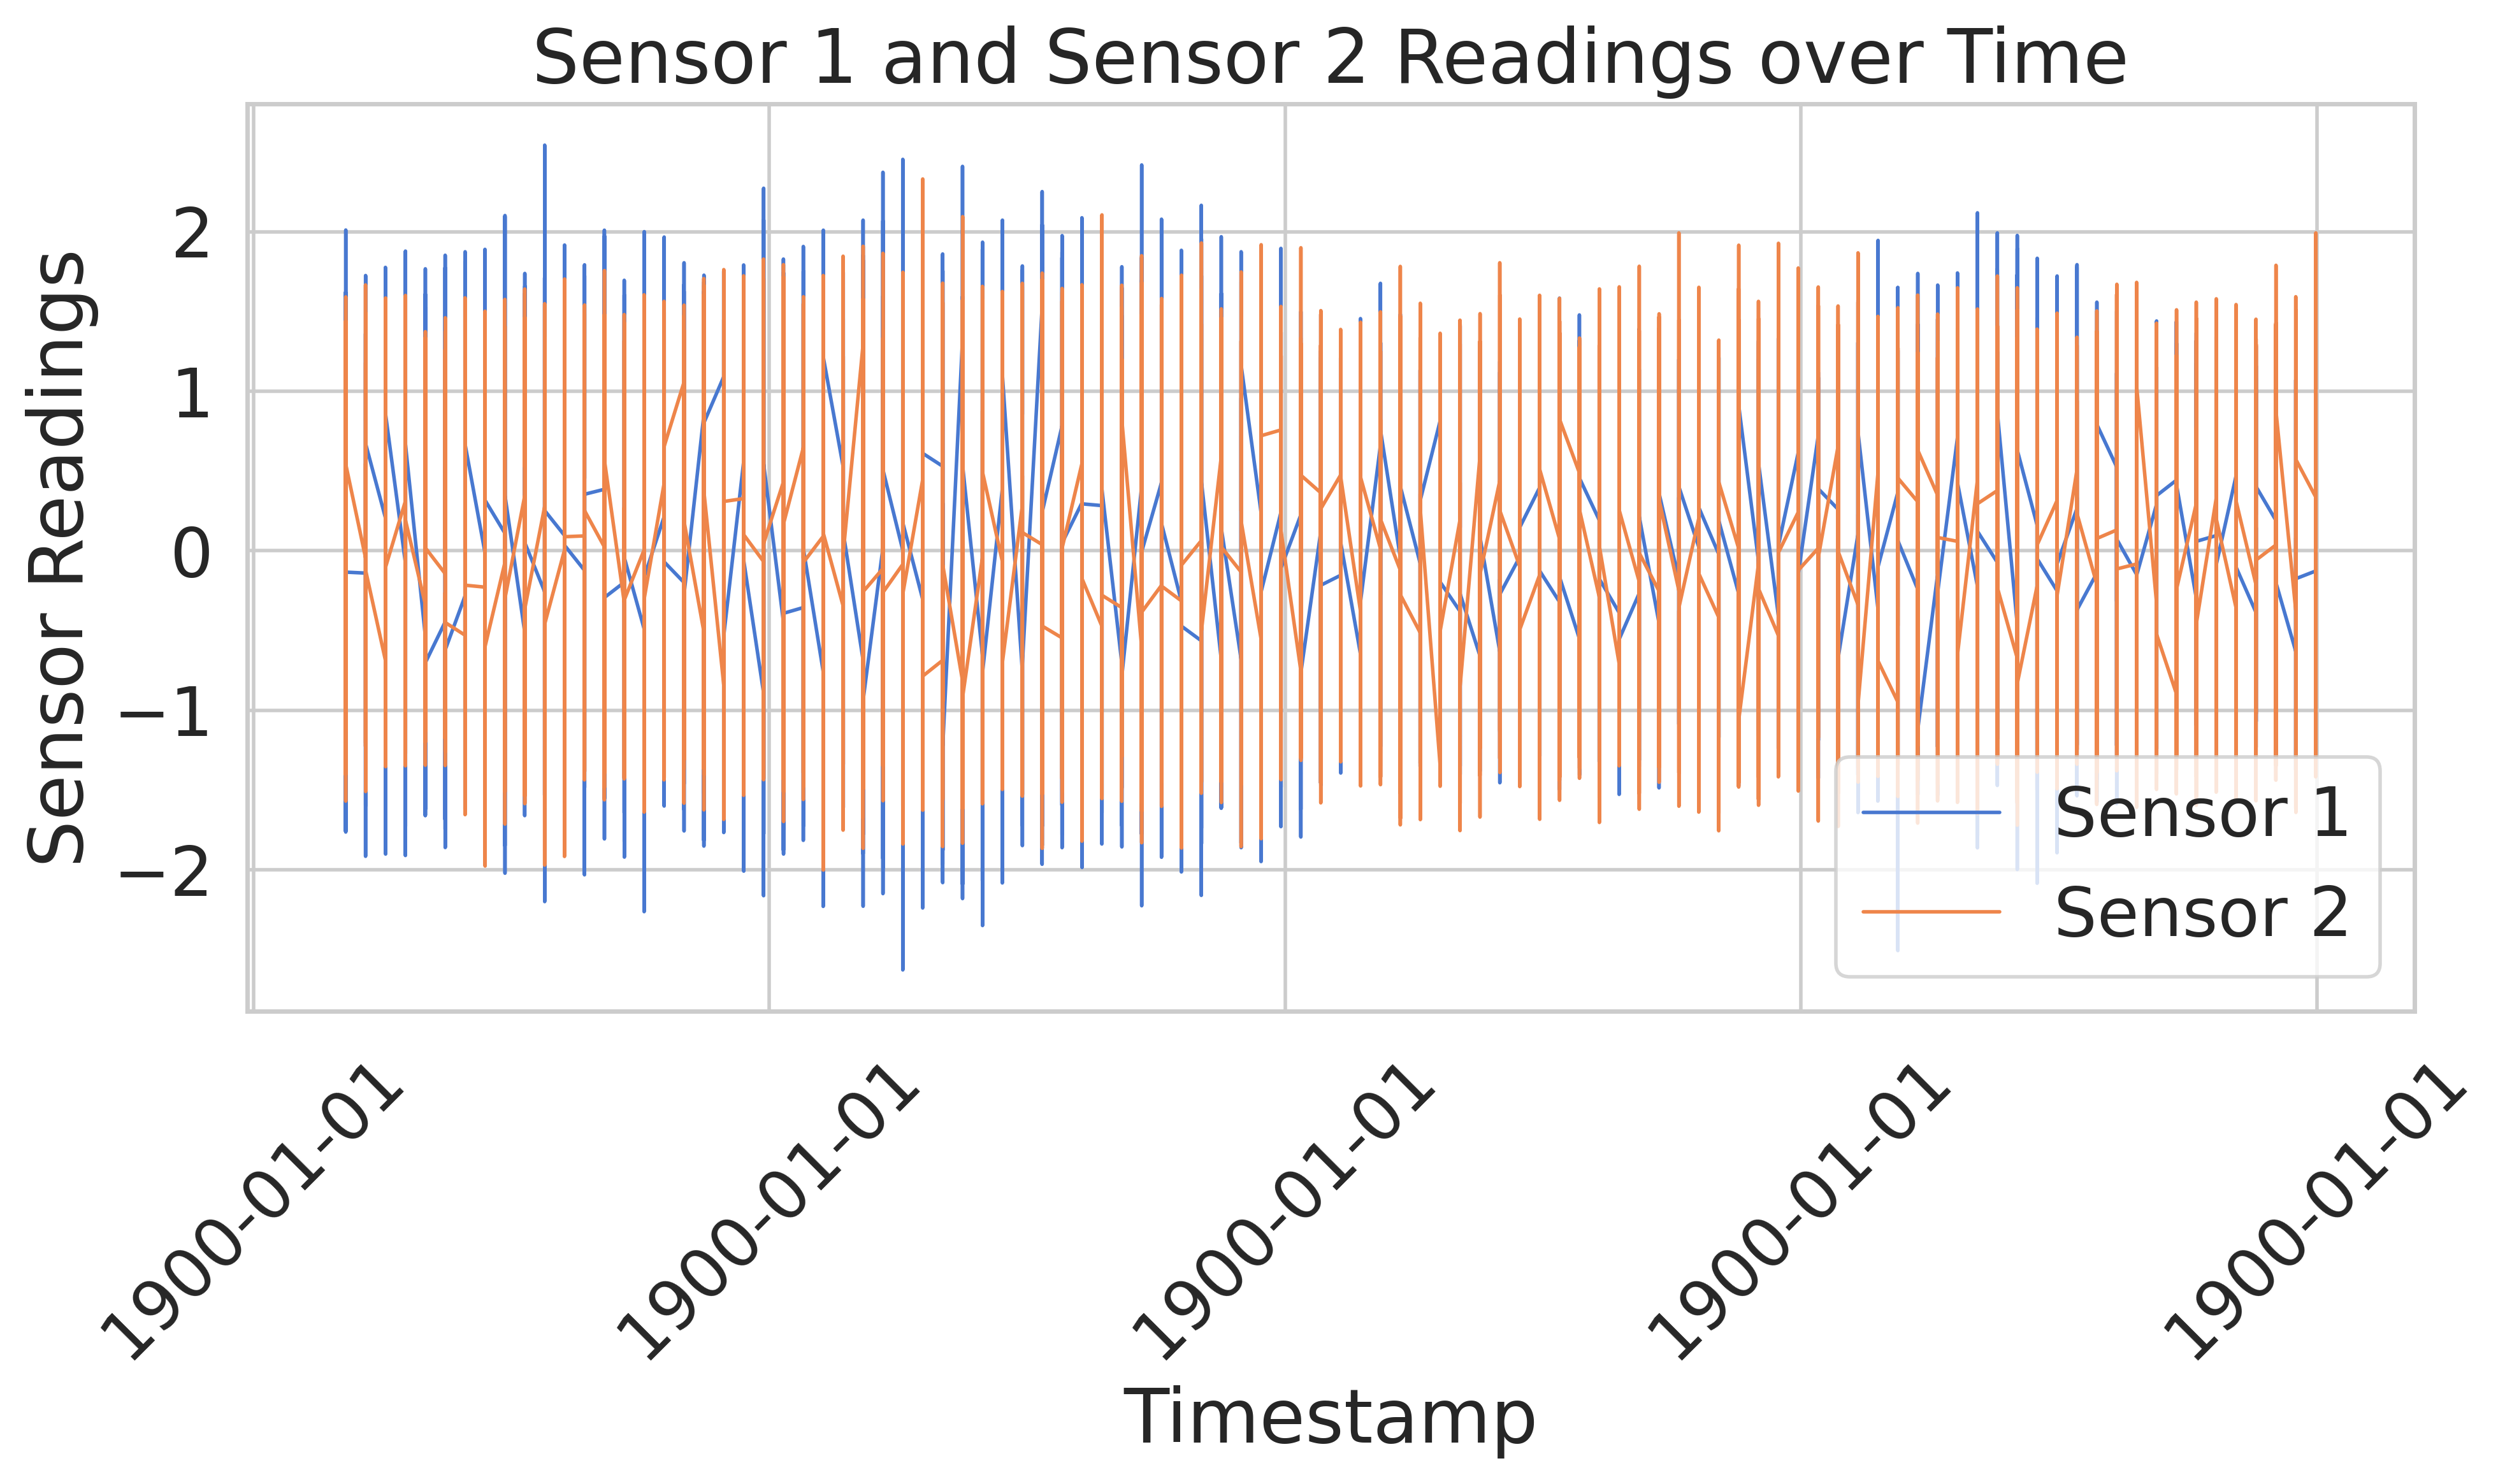

In [65]:
# Step 4: Plot the graph
plt.figure(figsize=(10, 6))

# Plot line graphs with narrower lines
plt.plot(combined_data['timestamp'], combined_data[4], label='Sensor 1', linewidth=1)
plt.plot(combined_data['timestamp'], combined_data[5], label='Sensor 2', linewidth=1)

plt.xlabel('Timestamp')
plt.ylabel('Sensor Readings')
plt.title('Sensor 1 and Sensor 2 Readings over Time')
plt.legend()
plt.xticks(rotation=45)
# plt.xlim(combined_data.index.min(), combined_data.index.max())  # Set x-axis limits to show the full time range
plt.tight_layout()

# Set x-axis tick frequency to display every 5 seconds (adjust as needed)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()